In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

###################### Inisiasi ###################
file = 'DTVir.txt'
t = np.loadtxt(file, usecols=0)
m = np.loadtxt(file, usecols=1)
merr = 0.01

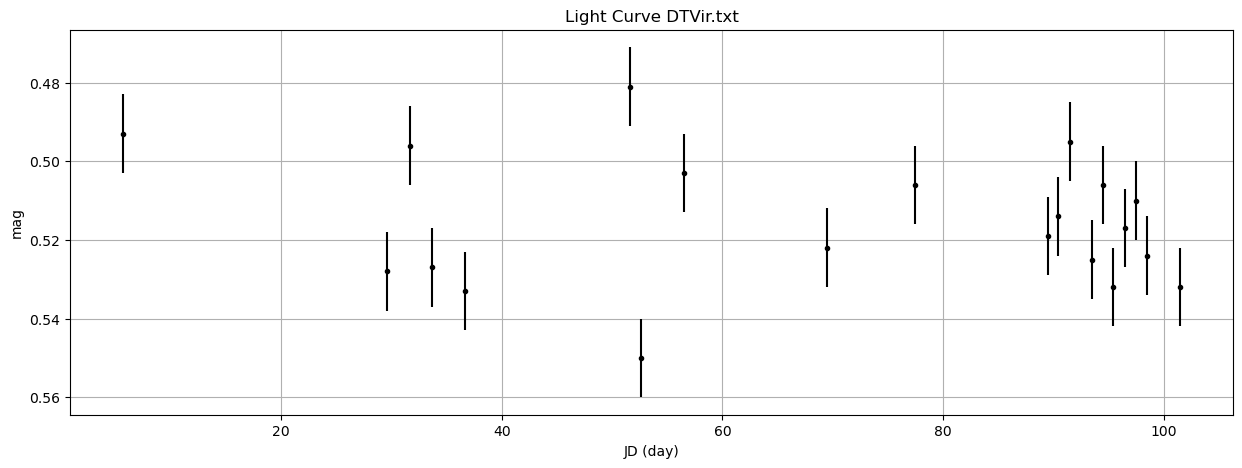

In [4]:
######################## Plot #####################

plt.figure(0,figsize=(15,5))
plt.errorbar(t, m, yerr=merr, fmt='k.')
plt.xlabel('JD (day)')
plt.gca().invert_yaxis()
plt.ylabel('mag')
plt.title('Light Curve %s'%file)
plt.grid(True)
plt.show()

In [5]:
###################### Config 1 ###########################
t0 = t[0]
mulai = t0 # 'Input first day of the light curve plot
selesai = t[len(t)-1] # 'Input last day of the light curve plot

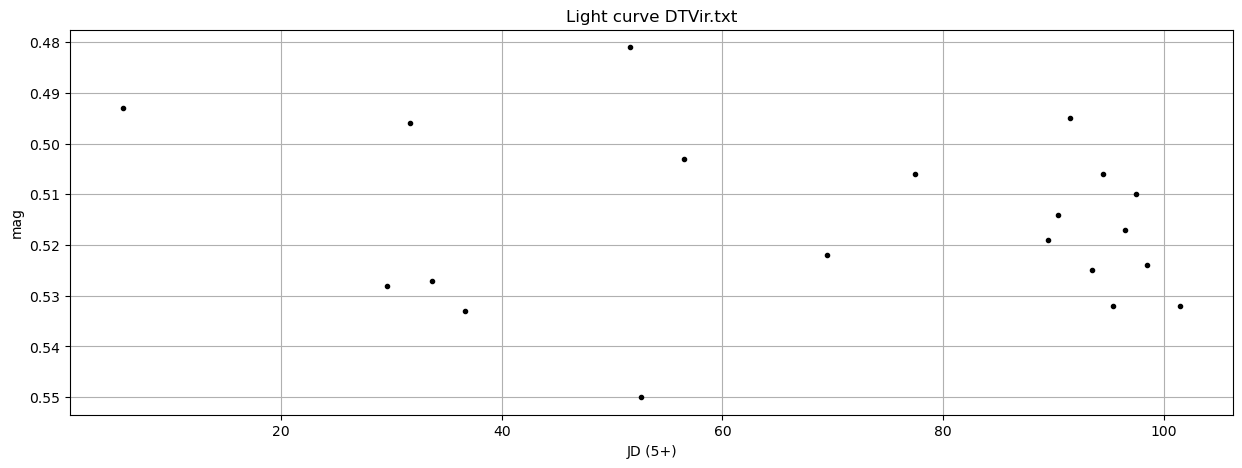

In [7]:
###################### Inisisasi 2 ###########################
t2 = []
m2 = []
count = 0
N = len(t)
while mulai > t[count]:
    count +=1
while selesai >= t[count]:
    t2.append(t[count])
    m2.append(m[count])
    count += 1
    if count == N:
        break
t = np.array(t2)
m = np.array(m2)
N = len(t)

######################## Plot #####################

plt.figure(0,figsize=(15,5))
plt.plot(t, m, 'k.')
plt.xlabel('JD (%d+)'%t0)
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.title(f'Light curve {file}')
plt.grid(True)
plt.show()

In [8]:
######### perhitungan ##########
mr = np.mean(m)  # Mag rata-rata
f = m - mr       # simpangan dari rerata
Difdate = np.diff(t)  # Mencari selisih antar pengamatan
NP = 2*min(Difdate)  # Periode Nyquist, 2xselisih minimum
fN = 1/NP  #1/Day  # Frekuensi Nyquist

####################### Config 2 ##################
fMax = fN # Input maximum frequency
Nfreq = 1000 # Input number of partition (number of data points)
Df = fMax/Nfreq # Selang frekuensi [CONST]
fMin = Df #Input the minimum frequency [resolution in requency]
###################################################

DT = t[N-1]-t[0]       #Lama observasi
Nfreq = int(fMax//Df)

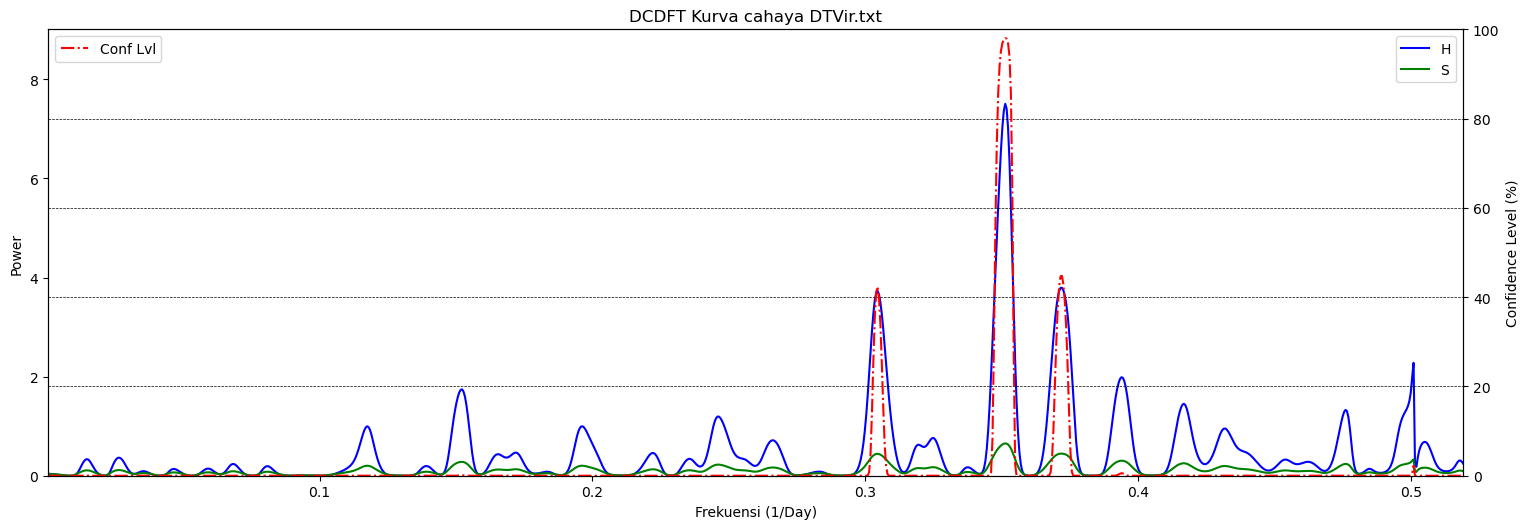

In [15]:
######### Perhitungan konstanta ##########
omega = np.linspace(fMin, fMax, Nfreq)    #bikin array omega

x = 2*np.pi*omega

a0 = np.sqrt(1/N)

S = np.zeros(Nfreq) 
C2 = []
C1 = []
A1 = []
A2 = []

for i in range(Nfreq):
    cos2x = np.sum(np.cos(x[i]*t)**2) 
    cosx2 = np.sum(np.cos(x[i]*t))**2
    sin2x = np.sum(np.sin(x[i]*t)**2) 
    sinx2 = np.sum(np.sin(x[i]*t))**2
    M = np.sum(np.cos(x[i]*t)*np.sin(x[i]*t)) - a0**2*np.sum(np.sin(x[i]*t))*np.sum(np.cos(x[i]*t))
    
    a1 = np.sqrt(1./(cos2x - a0**2*cosx2))
    a2 = np.sqrt(1./(sin2x - a0**2*sinx2 - a1**2*M**2))
    A1.append(a1)
    A2.append(a2)
    c1 = a1*np.sum(f*np.cos(x[i]*t))
    c2 = a2*np.sum(f*np.sin(x[i]*t)) - a1*a2*c1*M
    C2.append(c2)
    C1.append(c1)
    S[i] = (c1**2+c2**2)/np.sum(f**2)
    
G = -(N-3)/2*np.log(1-S)
H = (N-4)/(N-3)*(G+np.exp(-G)-1)
alpha = 2*(N-3)*DT*fMax/(3*(N-4))
C = 100*(1-np.exp(-H))**alpha
period = 1/omega[np.argmax(H)]

############## Plot DCDFT ######################

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(omega, H, 'b-', label = 'H')
ax1.plot(omega, S, 'g-', label = 'S')
ax2 = ax1.twinx()
ax2.plot(omega, C, 'r-.', label = 'Conf Lvl')
fig.tight_layout()
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
ax1.set_xlabel('Frekuensi (1/Day)')
ax1.set_ylabel('Power')
ax2.set_ylabel('Confidence Level (%)')
ax1.set_title('DCDFT Kurva cahaya %s'%file)
ax1.set_xlim(fMin,fMax)
plt.gca().invert_yaxis()
ax2.grid(color='k', linestyle='--', linewidth=.5, which='both', axis='y')
ax2.set_ylim(0,100)
ax1.set_ylim(0,max(H)*1.2)
plt.show()


Period = 2.846265 days(s)
Frequency = 0.351338 /day
Confidence Interval = 98.079292%


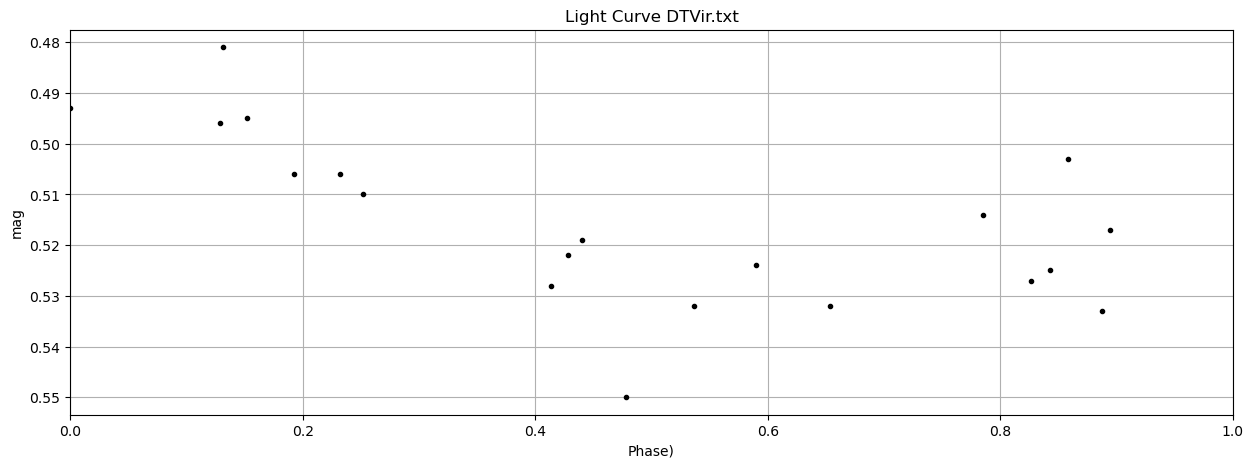

In [16]:
########### Menentukan fase dan plot kurva cahayanya ##############

print('Period = %f days(s)'%period)
print('Frequency = %f /day'%omega[np.argmax(H)])

print('Confidence Interval = %f%%' %max(C))
Ya = input('Use the period to plot the light curve? (y/n) = ')
if Ya == 'n':
    period = float(input('Input the period = '))
fase = (t-t[0])/period - (t-t[0])//period

plt.figure(0,figsize=(15,5))
plt.plot(fase, m, 'k.')
plt.ylim(mr+min(f)*1.1,mr+max(f)*1.1)
plt.gca().invert_yaxis()
plt.xlabel('Phase)')
plt.ylabel('mag')
plt.xlim(0,1)
plt.title('Light Curve %s'%file)
plt.grid(True)
plt.show()

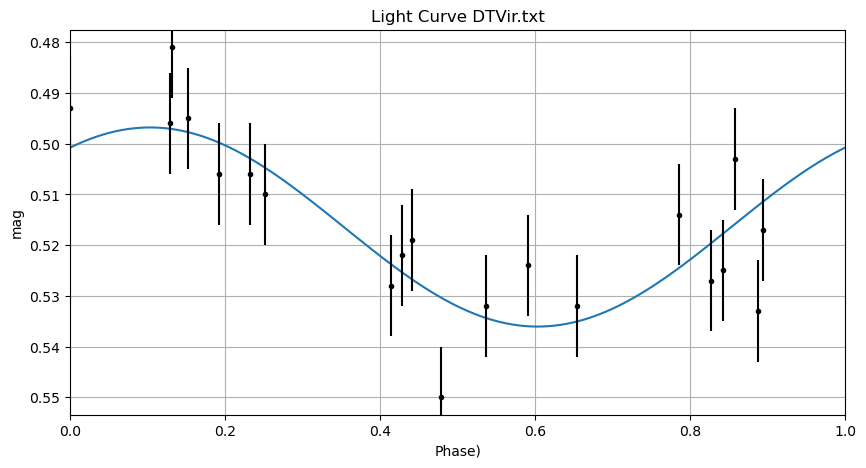

mean =  0.5164279883045227
amplitude =  0.019627702945629585
phase_0 =  0.6471099210519228


In [135]:
def model(phase, mean, amplitude, phase0):
    return amplitude*np.sin(phase*2*np.pi+phase0*2*np.pi)+mean

phase = np.linspace(0,1,1000)
phase0 = 0.65
amplitude = 0.02
mean = 0.51

popt, pcov = curve_fit(model, fase, m, p0=(mean, amplitude, phase0))

magnitude = model(phase, popt[0], popt[1], popt[2])

plt.figure(figsize=(10,5))
plt.plot(phase, magnitude)
plt.errorbar(fase, m, yerr=merr, fmt='k.')
plt.ylim(mr+min(f)*1.1,mr+max(f)*1.1)
plt.xlabel('Phase)')
plt.ylabel('mag')
plt.xlim(0,1)
plt.title('Light Curve %s'%file)
plt.grid(True)
plt.gca().invert_yaxis()
plt.savefig('LightCurve-No-Uncertainty.png')
plt.show()
print('mean = ', popt[0])
print('amplitude = ', popt[1])
print('phase_0 = ', popt[2])

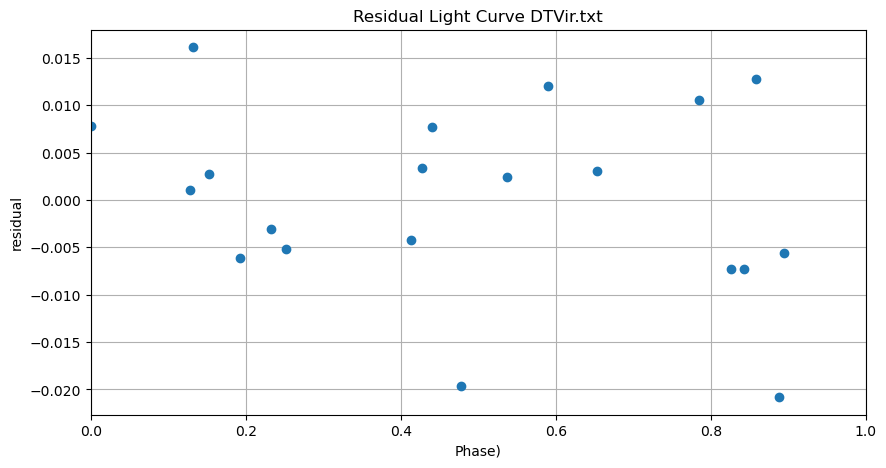

mean_residual = -2.2263968446623038e-12
sigma_residual = 0.009705408751659428


In [14]:
residual = model(fase, popt[0], popt[1], popt[2]) - m

plt.figure(figsize=(10,5))
plt.plot(fase, residual, 'o')
# plt.ylim(mr+min(f)*1.1,mr+max(f)*1.1)
plt.xlabel('Phase)')
plt.ylabel('residual')
plt.xlim(0,1)
plt.title('Residual Light Curve %s'%file)
plt.grid(True)
plt.show()

mean_residual = np.mean(residual)
sigma_residual = np.std(residual)
print('mean_residual =', mean_residual)
print('sigma_residual =', sigma_residual)

# With uncertainties

In [ ]:
from scipy.stats import uniform, norm
import emcee
from package import plot_chain, hdi_sample
import corner
from tqdm import tqdm

In [49]:
def log_prior(theta, locs, scales):
  return np.sum(uniform.logpdf(theta, locs, scales))

def log_likelihood(theta, data):
  p = theta[0]
  mean = theta[1]
  amplitude = theta[2]
  phase0 = theta[3]

  t = data[0]
  m = data[1]
  merr = data[2]

  phase = (t-t[0])/p - (t-t[0])//p
  mod = model(phase, mean, amplitude, phase0)
  log_prob = norm.logpdf(m, loc=mod, scale=merr)
  return np.sum(log_prob)

def log_posterior(theta, data, locs, scales):
  log_prior_val = log_prior(theta, locs, scales)
  if np.isinf(log_prior_val):
    return -np.inf
  return log_prior_val + log_likelihood(theta, data)

In [87]:
init = {
  'p': {
    'loc': period*0.99,
    'scale': period*0.02,
  },
  'mean': {
    'loc': 0.49,
    'scale': 0.04,
  },
  'amplitude': {
    'loc': 0.01,
    'scale': 0.02,
  },
  'phase0': {
    'loc': 0.2,
    'scale': 0.8,
  }
}

locs = [init[key]['loc'] for key in init]
scales = [init[key]['scale'] for key in init]

ndim = len(locs)
nwalkers = ndim * 10

p0 = np.array([uniform.rvs(loc=locs[i], scale=scales[i], size=nwalkers) for i in range(ndim)]).T
data = np.array([t, m, np.repeat(merr, len(m))])

p0.shape, data.shape

((40, 4), (3, 20))

In [88]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, locs, scales])
state = sampler.run_mcmc(p0, 100)

d:\dev\python\AsPeng\package.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


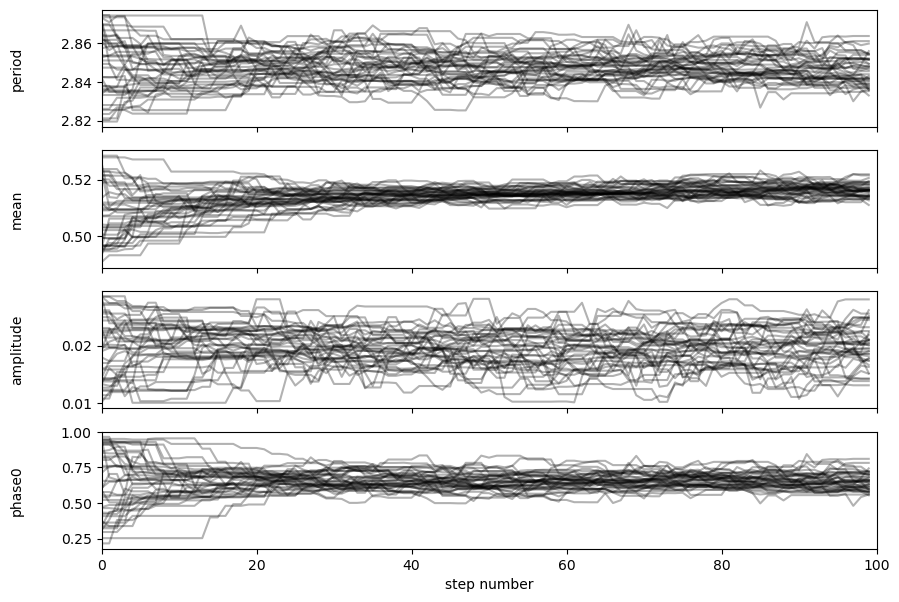

In [90]:
labels = ["period", "mean", "amplitude", "phase0"]
fig = plot_chain(sampler, labels=labels)

In [91]:
sampler.reset()
sampler.run_mcmc(state, 5000, progress=True);

100%|██████████| 5000/5000 [01:33<00:00, 53.39it/s]


State([[2.83866321 0.52170547 0.0214587  0.62800183]
 [2.8450867  0.51530438 0.01548148 0.61896088]
 [2.8471014  0.51979879 0.02101371 0.68062629]
 [2.85170897 0.51836206 0.01827945 0.70453419]
 [2.84700038 0.519189   0.02021138 0.636951  ]
 [2.84306376 0.51582204 0.01650188 0.58814383]
 [2.84492818 0.52012488 0.0241477  0.60130048]
 [2.83263646 0.51568341 0.01601193 0.52927602]
 [2.85841964 0.51792152 0.02121603 0.74464141]
 [2.85432486 0.5126295  0.01800579 0.72002839]
 [2.83898729 0.5123085  0.02478889 0.60202446]
 [2.84451192 0.51607137 0.02542977 0.66128893]
 [2.84030759 0.51677952 0.02036976 0.59378019]
 [2.84993868 0.51532309 0.01935067 0.68749011]
 [2.8494066  0.51963183 0.01829651 0.67963681]
 [2.8429438  0.5161335  0.02359421 0.66252611]
 [2.84943789 0.52075212 0.01871662 0.72276146]
 [2.84870113 0.51657298 0.02693763 0.61241098]
 [2.85752496 0.51686819 0.01722956 0.79186006]
 [2.85059307 0.51554598 0.02239467 0.66177271]
 [2.84952059 0.51743724 0.01931738 0.70655205]
 [2.852

d:\dev\python\AsPeng\package.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


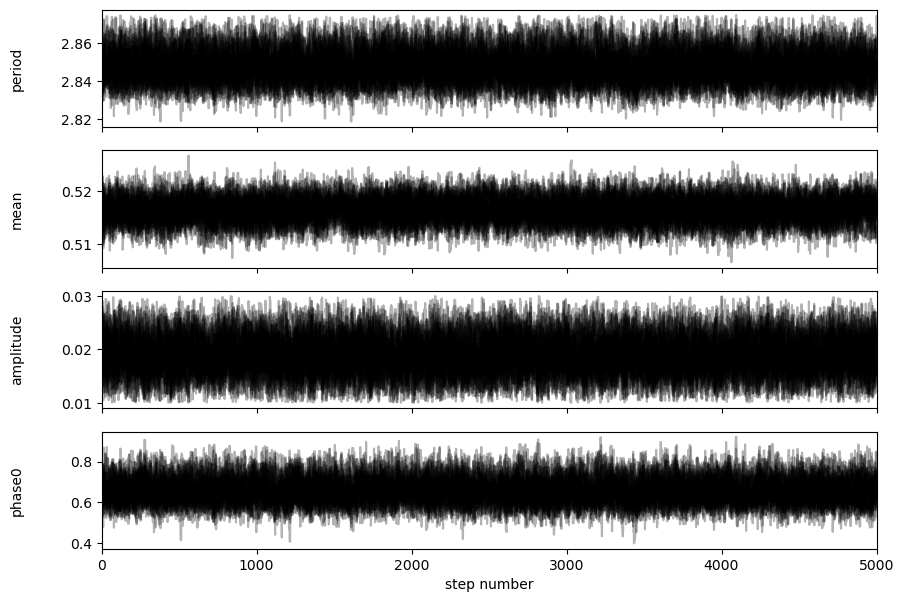

In [92]:
fig = plot_chain(sampler)

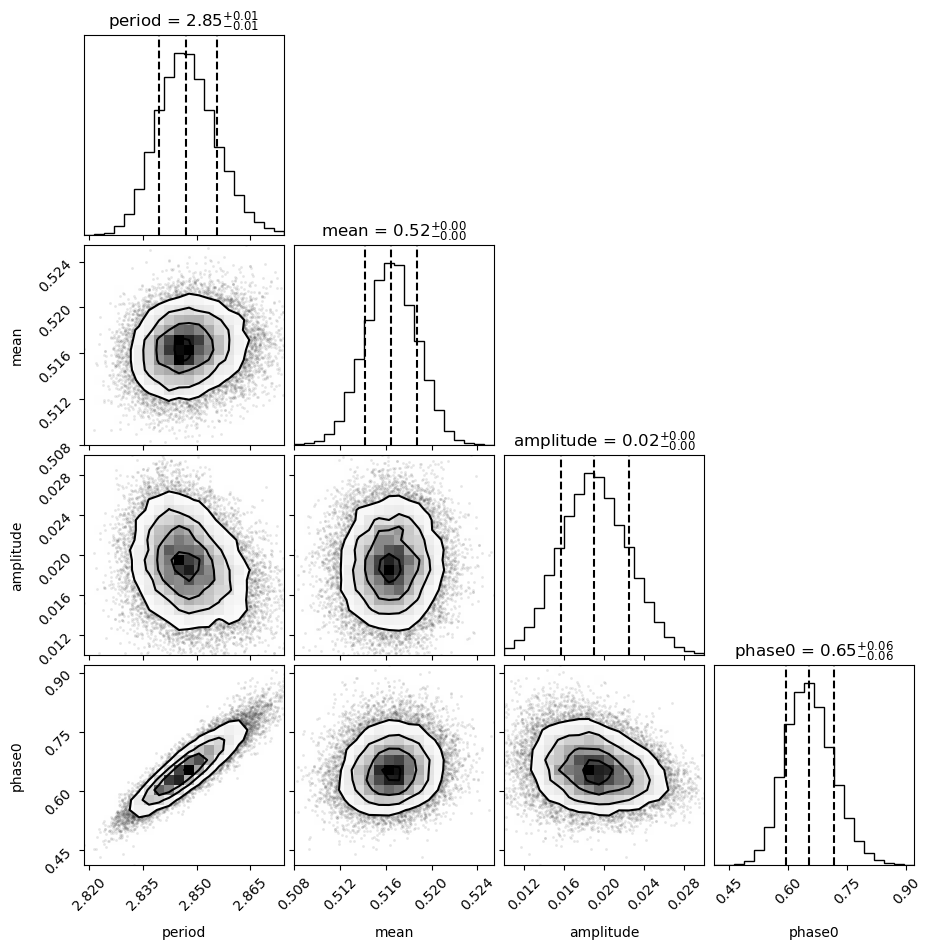

In [94]:
flat_samples = sampler.get_chain(thin=10, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},

)

In [95]:
from scipy.stats import gaussian_kde

def hdi_sample(sample, low=None, high=None, alpha=0.05, roundto=2, res=2000, precision=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode

    Parameters
    ----------
    
    func : function
        Function
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results

    Returns
    ----------
    hpd: array with the lower 
          
    """
    low = np.min(sample) if low is None else low
    high = np.max(sample) if high is None else high
    x = np.linspace(low, high, res)
    y = gaussian_kde(sample)(x)
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (high-low)*precision  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
         modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, modes

In [131]:
theta = flat_samples[np.random.choice(flat_samples.shape[0], 10000, replace=False)]

phases = np.linspace(0, 1, 100)
mag_uppers = np.empty(len(phases))
mag_lowers = np.empty(len(phases))
mag_modes = np.empty(len(phases))
for i, phase in enumerate(tqdm(phases)):
  mean = theta[:, 1]
  amplitude = theta[:, 2]
  phase0 = theta[:, 3]
  mag_mod = amplitude*np.sin(phase*2*np.pi+phase0*2*np.pi)+mean
  hpd, modes = hdi_sample(mag_mod, low=0, high=1, alpha=0.1, roundto=5, res=10000, precision=0.001)
  mag_lowers[i] = hpd[0][0]
  mag_uppers[i] = hpd[0][1] 
  mag_modes[i] = modes[0]

100%|██████████| 100/100 [09:56<00:00,  5.97s/it]


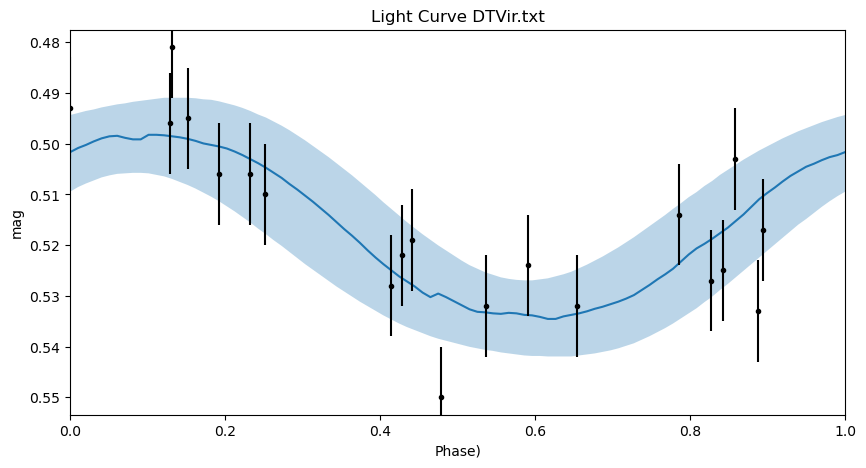

In [136]:
plt.figure(figsize=(10,5))
plt.plot(phases, mag_modes, label='mode')
plt.fill_between(phases, mag_lowers, mag_uppers, alpha=0.3, label='90% HDI')
plt.errorbar(fase, m, yerr=merr, fmt='k.')
plt.ylim(mr+min(f)*1.1,mr+max(f)*1.1)
plt.gca().invert_yaxis()
plt.xlabel('Phase)')
plt.ylabel('mag')
plt.xlim(0,1)
plt.title(f'Light Curve {file}')
plt.savefig('LightCurveOfDTVir.png')
plt.show()